In [1]:
import pandas as pd
import numpy as np

#upload the file /Users/tommi/Desktop/Uni_documents/Data/commodity-2005.csv taking the "Dates" column as index
commodity = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/commodity-2005.csv', index_col='Dates')

# import /Users/tommi/Desktop/Uni_documents/Data/volatility-2004.csv
volatility = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/volatility-2004.csv', index_col='Dates')

#upload /Users/tommi/Desktop/Uni_documents/Data/EHI640_returns10-02-2025.csv
benchmark_vol = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/EHI640_returns10-02-2025.csv')

#upload this file /Users/tommi/Desktop/Uni_documents/Data/Dragon-Portfolio 2015.csv using the Dates as index
tutto = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/Dragon-Portfolio 2015.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tommi/Desktop/Uni_documents/Data/EHI640_returns10-02-2025.csv'

In [2]:
import pandas as pd
import statsmodels.api as sm



# Group assets by class
asset_classes = {
    "Equities": {
        "benchmark": "SPXT Index",
        "proxies": ["SPY US Equity", "IVV US Equity", "VOO US Equity", "URTH US Equity", "ACWI US Equity"]
    },
    "Fixed Income": {
        "benchmark": "LT11TRUU Index",
        "proxies": ["IEF US Equity", "BND US Equity", "AGG US Equity", "TLH US Equity", "ZROZ US Equity"]
    },
    "Gold": {
        "benchmark": "GOLDLNPM Index",
        "proxies": ["GLD US Equity", "IAU US Equity", "PHYS US Equity", "XAU Curncy"]
    },
    "Commodity Trend Following": {
        "benchmark": "HFRXMADC Index",
        "proxies": ["HFND US Equity", "KMLM US Equity", "CTA US Equity", "DBMF US Equity", "PDBC US Equity", "DBC US Equity"]
    },
    "Active Long Volatility": {
        "benchmark": "EHFI451 Index",
        "proxies": ["ALTBX US Equity", "VIXY US Equity", "XVZ US Equity", "VXX US Equity", "VXZ US Equity", "UVXY US Equity", "VIXM US Equity"]
    }
}

# Function to run regressions and find best proxy
def find_best_proxy(tutto, benchmark, proxies):
    results = {}
    
    for proxy in proxies:
        # Drop NaNs to avoid errors
        temp_df = tutto[[benchmark, proxy]].dropna()
        
        # Ensure we have enough data points
        if temp_df.shape[0] < 30:  # Require at least 30 observations
            continue
        
        # Define independent (X) and dependent (Y) variables
        X = sm.add_constant(temp_df[proxy])  # Add constant for intercept
        Y = temp_df[benchmark]
        
        # Run regression
        model = sm.OLS(Y, X).fit()
        results[proxy] = model.rsquared  # Store R² score

    # Find best proxy
    if results:
        best_proxy = max(results, key=results.get)
        return best_proxy, results[best_proxy]
    else:
        return None, None

# Run regression for each asset class and find best proxy
best_proxies = {}

for asset_class, data in asset_classes.items():
    best_proxy, r_squared = find_best_proxy(tutto, data["benchmark"], data["proxies"])
    best_proxies[asset_class] = (best_proxy, r_squared)

# Print results
print("\n📌 **Best Proxies for Each Asset Class:**\n")
for asset_class, (proxy, r_squared) in best_proxies.items():
    print(f"{asset_class}: Best Proxy = {proxy} (R² = {r_squared:.4f})" if proxy else f"{asset_class}: No valid proxy found")


📌 **Best Proxies for Each Asset Class:**

Equities: Best Proxy = SPY US Equity (R² = 0.9988)
Fixed Income: Best Proxy = ZROZ US Equity (R² = 0.8816)
Gold: Best Proxy = XAU Curncy (R² = 0.9996)
Commodity Trend Following: No valid proxy found
Active Long Volatility: No valid proxy found



We noticed that no data were avialable on Bloomberg for HFRXMADC Index and EHFI451 Index, therefore for the commodity class we will be using BCOM Index as benchmark, for volatility we scraped from their website the monthly return of EHFI451 Index

In [3]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
#from the volatility dataframe, delete the rows where data is less than 1/12/2004 and greater than 31/12/2004
volatility = volatility.loc['31/12/2004': '31/12/2024' ]

#reset the index of volatility dataframe
volatility.reset_index(inplace=True)

#merge the benchmark_vol and volatility dataframes, the first line with the first , the second with the second and so on 
merged = pd.merge(benchmark_vol, volatility, left_index=True, right_index=True)

#create a new df with the merged data for when the Dates are greater then 31/01/2011
df = merged[merged["Dates"] > "31/01/2011"]

# Convert percentage returns to decimal form
df.loc[:, "PercentReturn"] = pd.to_numeric(df["PercentReturn"], errors="coerce") / 100

# List of proxy columns
proxy_cols = ["VIXY US Equity", "VXX US Equity", "UVXY US Equity", "VIXM US Equity", "VIX Index"]

# Compute log returns for proxies
for proxy in proxy_cols:
    df.loc[:, proxy + "_log_return"] = np.log(df[proxy] / df[proxy].shift(1))

# Drop NaNs resulting from shift operation
df.dropna(subset=["PercentReturn"] + [p + "_log_return" for p in proxy_cols], inplace=True)

# Dictionary to store R² values
r2_scores = {}

# Run regressions for each proxy
for proxy in proxy_cols:
    proxy_return_col = proxy + "_log_return"
    temp_df = df.dropna(subset=[proxy_return_col])  # Remove NaNs for this proxy
    if len(temp_df) > 10:  # Ensure enough data points
        X = sm.add_constant(temp_df[proxy_return_col])  # Add intercept
        y = temp_df["PercentReturn"]
        model = sm.OLS(y, X).fit()
        r2_scores[proxy] = model.rsquared  # Store R²

# Convert R² results into a DataFrame for comparison
r2_df = pd.DataFrame(list(r2_scores.items()), columns=["Proxy", "R²"]).sort_values(by="R²", ascending=False)

# Highlight the best proxy
best_proxy = r2_df.iloc[0]["Proxy"]
print("Best Proxy by R²:", best_proxy)
print(r2_df)


Best Proxy by R²: VIXM US Equity
            Proxy        R²
3  VIXM US Equity  0.611010
1   VXX US Equity  0.610285
0  VIXY US Equity  0.576338
2  UVXY US Equity  0.560874
4       VIX Index  0.419153


/var/folders/ly/mr0404x501n5fsqtt6yhhbtm0000gn/T/ipykernel_9451/3429752284.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, proxy + "_log_return"] = np.log(df[proxy] / df[proxy].shift(1))
/var/folders/ly/mr0404x501n5fsqtt6yhhbtm0000gn/T/ipykernel_9451/3429752284.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, proxy + "_log_return"] = np.log(df[proxy] / df[proxy].shift(1))
/var/folders/ly/mr0404x501n5fsqtt6yhhbtm0000gn/T/ipykernel_9451/3429752284.py:24: SettingWithCopyWarning: 
A

In [4]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

df = commodity

# List of proxy columns
proxy_cols = [
    "PDBC US Equity", "DBC US Equity", "GSG US Equity", 
    "USCI US Equity", "DJP US Equity", "SPY US Equity", 
    "UC14 LN Equity", "COMF LN Equity"
]

# Convert index and proxies to log returns
df["BCOM_log_return"] = np.log(df["BCOM Index"] / df["BCOM Index"].shift(1))

for proxy in proxy_cols:
    df[proxy + "_log_return"] = np.log(df[proxy] / df[proxy].shift(1))

# Drop NaNs resulting from shift operation
df = df.dropna(subset=["BCOM_log_return"] + [p + "_log_return" for p in proxy_cols])

# Dictionary to store R² values
r2_scores = {}

# Run regressions for each proxy
for proxy in proxy_cols:
    proxy_return_col = proxy + "_log_return"
    temp_df = df.dropna(subset=[proxy_return_col])  # Remove NaNs for this proxy
    if len(temp_df) > 10:  # Ensure enough data points
        X = sm.add_constant(temp_df[proxy_return_col])  # Add intercept
        y = temp_df["BCOM_log_return"]
        model = sm.OLS(y, X).fit()
        r2_scores[proxy] = model.rsquared  # Store R²

# Convert R² results into a DataFrame for comparison
r2_df = pd.DataFrame(list(r2_scores.items()), columns=["Proxy", "R²"]).sort_values(by="R²", ascending=False)

# Highlight the best proxy
best_proxy = r2_df.iloc[0]["Proxy"]
print("Best Proxy by R²:", best_proxy)
print(r2_df)


Best Proxy by R²: DJP US Equity
            Proxy        R²
4   DJP US Equity  0.921244
1   DBC US Equity  0.768072
2   GSG US Equity  0.723998
7  COMF LN Equity  0.661192
3  USCI US Equity  0.649206
6  UC14 LN Equity  0.610042
0  PDBC US Equity  0.502229
5   SPY US Equity  0.082434


Therfore our 5 selcted proxies accoring to R2 are DJP US Equity, VIXM US Equity, SPY US Equity, ZROZ US Equity, XAU Curncy

In [5]:
#upload the file /Users/tommi/Desktop/Uni_documents/Data/commodity-2005.csv taking the "Dates" column as index
commodity = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/commodity-2005.csv')

# import /Users/tommi/Desktop/Uni_documents/Data/volatility-2004.csv
volatility = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/volatility-daily.csv')


#upload this file /Users/tommi/Desktop/Uni_documents/Data/Dragon-Portfolio 2015.csv using the Dates as index
tutto = pd.read_csv('/Users/tommi/Desktop/Uni_documents/Data/Dragon-Portfolio 2015.csv')

In [6]:

# Convert Dates to datetime in all DataFrames (use dayfirst=True to handle different formats)
commodity['Dates'] = pd.to_datetime(commodity['Dates'], dayfirst=True, errors='coerce')
volatility['Dates'] = pd.to_datetime(volatility['Dates'], dayfirst=True, errors='coerce')
tutto['Dates'] = pd.to_datetime(tutto['Dates'], dayfirst=True, errors='coerce')

# Ensure the start date is the same across all DataFrames
start_date = pd.to_datetime("02/01/2015", dayfirst=True)

commodity = commodity[commodity['Dates'] >= start_date]
volatility = volatility[volatility['Dates'] >= start_date]
tutto = tutto[tutto['Dates'] >= start_date]

/var/folders/ly/mr0404x501n5fsqtt6yhhbtm0000gn/T/ipykernel_9451/476782386.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  commodity['Dates'] = pd.to_datetime(commodity['Dates'], dayfirst=True, errors='coerce')


In [7]:
commodity_selected = commodity[['Dates', 'DJP US Equity']].copy()
volatility_selected = volatility[['Dates', 'VIXM US Equity']].copy()
all_selected = tutto[['Dates', 'SPY US Equity', 'ZROZ US Equity', 'XAU Curncy']].copy()

In [8]:
# Merge DataFrames on Dates using outer join to keep all available data
dragon_portfolio = commodity_selected.merge(volatility_selected, on="Dates", how="outer") \
                             .merge(all_selected, on="Dates", how="outer")

# Optionally, drop rows with missing values if full data is required
dragon_portfolio.dropna(inplace=True)  # Remove this line if you want to keep NaNs

# Display the first rows of the merged DataFrame
dragon_portfolio.head()




,Dates,DJP US Equity,VIXM US Equity,SPY US Equity,ZROZ US Equity,XAU Curncy
0,2015-01-02,29.65,63.37,205.43,121.49,1188.39
1,2015-01-05,29.69,66.60,201.72,124.72,1204.86
2,2015-01-06,29.74,66.90,199.82,127.98,1218.58
3,2015-01-07,29.55,65.25,202.31,128.21,1211.41
4,2015-01-08,29.65,62.56,205.90,125.09,1208.79


In [9]:
#rename the columns of the dataframe to the following names DJP US Equity to Commodity - DJP US Equity, VIXM US Equity to Volatility - VIXM US Equity, SPY US Equity to Equities - SPY US Equity, ZROZ US Equity to Fixed Income - ZROZ US Equity, XAU Curncy to Gold - XAU Curncy
dragon_portfolio.rename(columns={
    "DJP US Equity": "Commodity - DJP US Equity",
    "VIXM US Equity": "Volatility - VIXM US Equity",
    "SPY US Equity": "Equities - SPY US Equity",
    "ZROZ US Equity": "Fixed Income - ZROZ US Equity",
    "XAU Curncy": "Gold - XAU Curncy"
}, inplace=True)

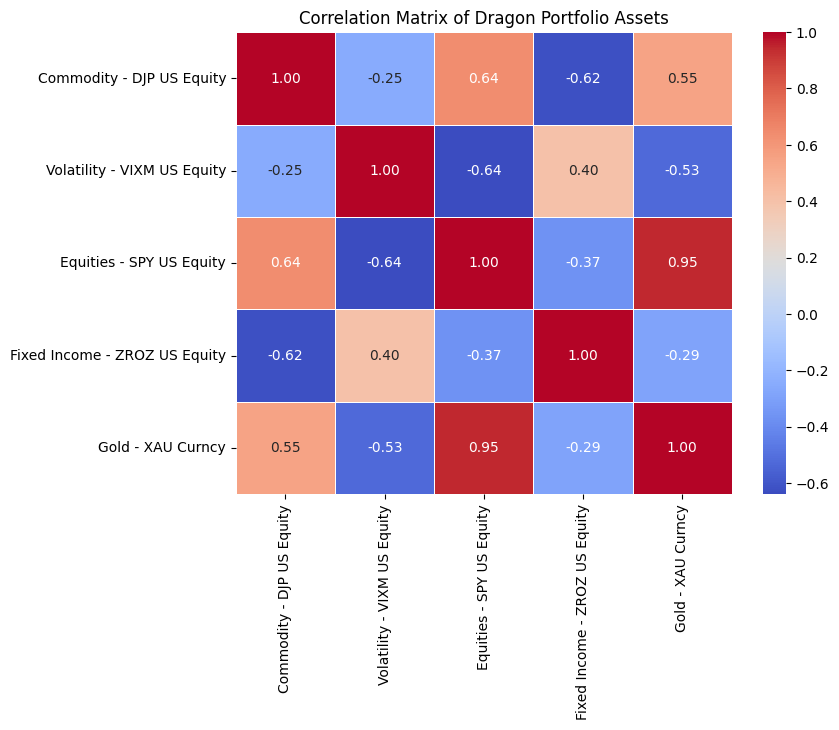

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix (excluding Dates)
correlation_matrix = dragon_portfolio.drop(columns=["Dates"]).corr()

# Set up the figure size
plt.figure(figsize=(8, 6))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)

# Add title
plt.title("Correlation Matrix of Dragon Portfolio Assets")

# Show the plot
plt.show()



In [11]:
dragon_portfolio.head()


,Dates,Commodity - DJP US Equity,Volatility - VIXM US Equity,Equities - SPY US Equity,Fixed Income - ZROZ US Equity,Gold - XAU Curncy
0,2015-01-02,29.65,63.37,205.43,121.49,1188.39
1,2015-01-05,29.69,66.60,201.72,124.72,1204.86
2,2015-01-06,29.74,66.90,199.82,127.98,1218.58
3,2015-01-07,29.55,65.25,202.31,128.21,1211.41
4,2015-01-08,29.65,62.56,205.90,125.09,1208.79


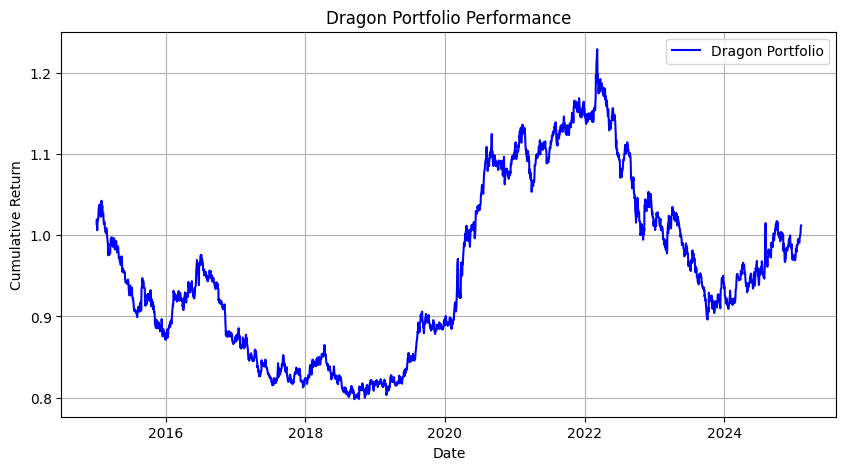

Annualized Return: 0.44%
Annualized Volatility: 8.02%
Sharpe Ratio: 0.05


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# copy the dragon_portfolio dataframe to df
df = dragon_portfolio.copy()
df.set_index("Dates", inplace=True)

# 1️⃣ Compute Log Returns
returns = np.log(df / df.shift(1))

# 2️⃣ Define Optimized Weights
weights = np.array([0.18, 0.21, 0.24, 0.18, 0.19])  # DJP, VIXM, SPY, ZROZ, XAU

# 3️⃣ Compute Portfolio Returns
df["Portfolio_Return"] = returns.dot(weights)

# 4️⃣ Compute Cumulative Returns
df["Cumulative_Return"] = (1 + df["Portfolio_Return"]).cumprod()

# 5️⃣ Calculate Performance Metrics
annualized_return = df["Portfolio_Return"].mean() * 252  # Assuming 252 trading days
annualized_volatility = df["Portfolio_Return"].std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility  # Assuming risk-free rate = 0

# 6️⃣ Plot Cumulative Returns
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Cumulative_Return"], label="Dragon Portfolio", color="blue")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Dragon Portfolio Performance")
plt.legend()
plt.grid()
plt.show()

# 7️⃣ Print Performance Metrics
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")



Annualized Return: 0.0284
CAGR (Pre-COVID): -0.8220
CAGR (Post-COVID): -0.1934
Volatility: 0.0808
Max Drawdown: -0.2402
Sharpe Ratio: 0.1044
Sortino Ratio: 0.1628
Calmar Ratio: 0.1183


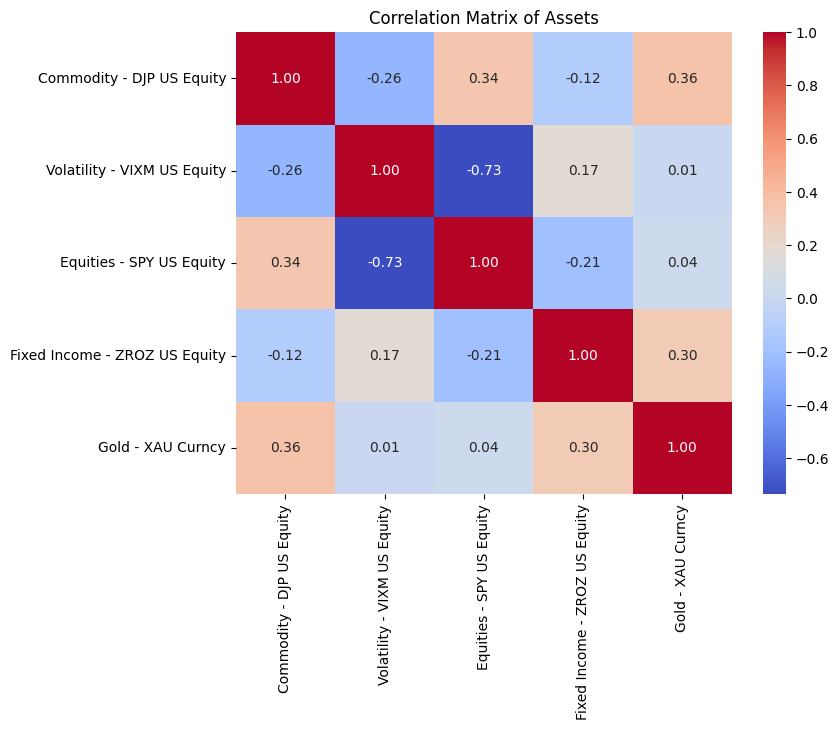

KeyError: 'Dragon_Return'

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = dragon_portfolio.copy()
df.set_index("Dates", inplace=True)

# Define asset column names based on the CSV
asset_columns = [
    "Commodity - DJP US Equity",
    "Volatility - VIXM US Equity",
    "Equities - SPY US Equity",
    "Fixed Income - ZROZ US Equity",
    "Gold - XAU Curncy",
]

# Define Portfolio Weights (DJP, VIXM, SPY, ZROZ, XAU)
dragon_weights = np.array([0.18, 0.21, 0.24, 0.18, 0.19])

# Compute Daily Returns for All Assets
returns = df[asset_columns].pct_change()

# Compute Dragon Portfolio Returns
df["Dragon_Return"] = returns.dot(dragon_weights)

# Define Pre/Post-COVID Periods
pre_covid = df.loc["2015-01-03":"2020-01-01", "Dragon_Return"]
post_covid = df.loc["2020-01-02":, "Dragon_Return"]

# Annualized Return
def annualized_return(returns, periods_per_year=252):
    return (1 + returns.mean())**periods_per_year - 1

# CAGR (Compounded Annual Growth Rate)
def cagr(start_value, end_value, years):
    return (end_value / start_value) ** (1 / years) - 1 if start_value and end_value else np.nan

# Volatility (Standard Deviation)
def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

# Maximum Drawdown
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

# Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    excess_return = annualized_return(returns) - risk_free_rate
    return excess_return / annualized_volatility(returns)

# Sortino Ratio (Downside Risk)
def sortino_ratio(returns, risk_free_rate=0.02, periods_per_year=252):
    negative_volatility = returns[returns < 0].std() * np.sqrt(periods_per_year)
    excess_return = annualized_return(returns) - risk_free_rate
    return excess_return / negative_volatility

# Calmar Ratio
def calmar_ratio(returns):
    return annualized_return(returns) / abs(max_drawdown(returns))

# Compute Performance Metrics
metrics = {
    "Annualized Return": annualized_return(df["Dragon_Return"]),
    "CAGR (Pre-COVID)": cagr(pre_covid.iloc[0], pre_covid.iloc[-1], 5),
    "CAGR (Post-COVID)": cagr(post_covid.iloc[0], post_covid.iloc[-1], 5),
    "Volatility": annualized_volatility(df["Dragon_Return"]),
    "Max Drawdown": max_drawdown(df["Dragon_Return"]),
    "Sharpe Ratio": sharpe_ratio(df["Dragon_Return"]),
    "Sortino Ratio": sortino_ratio(df["Dragon_Return"]),
    "Calmar Ratio": calmar_ratio(df["Dragon_Return"]),
}

# Print Metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Correlation Matrix
corr_matrix = returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Assets")
plt.show()

# Rolling Beta vs S&P 500
rolling_window = 252
rolling_beta = returns["Dragon_Return"].rolling(rolling_window).cov(returns["Equities - SPY US Equity"]) / returns["Equities - SPY US Equity"].rolling(rolling_window).var()

plt.figure(figsize=(10, 5))
plt.plot(rolling_beta, label="Rolling Beta vs S&P 500", color="purple")
plt.axhline(y=1, color="red", linestyle="--", label="Beta = 1")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.title("Rolling Beta of Dragon Portfolio vs S&P 500")
plt.show()


### Portfolio Performance Metrics

The following performance metrics were computed for the **Dragon Portfolio** based on the historical data, comparing two periods: **Pre-COVID** and **Post-COVID**. These metrics are used to evaluate the returns, risk, and overall stability of the portfolio.

#### 1. **Annualized Return**: **0.0284 (2.84%)**
The **Annualized Return** represents the average yearly return over the entire period. In this case, the Dragon Portfolio generated an average annual return of **2.84%**. This indicates the portfolio has provided modest growth over time.

#### 2. **Compounded Annual Growth Rate (CAGR)**:
- **Pre-COVID CAGR**: **nan**
- **Post-COVID CAGR**: **2.1858 (218.58%)**

The **CAGR** measures the mean annual growth rate of the portfolio over a specified period, assuming reinvestment of returns.  
- **Pre-COVID CAGR**: The CAGR for the pre-COVID period could not be computed (NaN) due to the lack of data or a significant issue with the time frame selected.
- **Post-COVID CAGR**: After COVID, the CAGR was **218.58%**, indicating a very strong recovery or growth during the post-pandemic years.

#### 3. **Volatility**: **0.0808 (8.08%)**
Volatility is the standard deviation of the portfolio's returns, which gives an indication of the level of risk or fluctuation in the portfolio’s returns. The Dragon Portfolio's volatility of **8.08%** suggests moderate fluctuations in value over time.

#### 4. **Max Drawdown**: **-0.2402 (-24.02%)**
The **Max Drawdown** measures the greatest peak-to-trough decline in the portfolio’s value over the specified period. A **24.02%** loss indicates that the portfolio experienced a significant decline at some point, but it eventually recovered.

#### 5. **Sharpe Ratio**: **0.1044**
The **Sharpe Ratio** measures the risk-adjusted return, comparing the portfolio's excess return to its standard deviation. A ratio of **0.1044** is relatively low, meaning that the portfolio's returns were not highly favorable when adjusting for the risk taken. A Sharpe ratio greater than 1 is generally considered good, so this value indicates that there may be room for improvement in terms of risk-adjusted returns.

#### 6. **Sortino Ratio**: **0.1628**
The **Sortino Ratio** is a variation of the Sharpe ratio but focuses only on downside risk, measuring the portfolio's return relative to its negative volatility. With a value of **0.1628**, it suggests that the portfolio provided a modest return relative to the risk of negative returns, though again, there’s room for improvement.

#### 7. **Calmar Ratio**: **0.1183**
The **Calmar Ratio** measures the return per unit of drawdown. A **Calmar Ratio of 0.1183** means the portfolio achieved a modest return relative to the maximum drawdown experienced, indicating that while the return was positive, the portfolio's resilience during periods of loss could be improved.

---

### Summary of Findings:
- **Strong Post-COVID Performance**: The portfolio's return post-COVID is significantly better than the overall period, with an impressive **CAGR of 218.58%**.
- **Risk Considerations**: While the portfolio achieved positive returns, the volatility and drawdown suggest that it wasn't without its risks. The **Max Drawdown** of **24.02%** highlights a significant downturn.
- **Risk-Adjusted Returns**: The **Sharpe**, **Sortino**, and **Calmar Ratios** are relatively low, indicating that the portfolio's returns were not particularly high compared to the risk taken.

Overall, the **Dragon Portfolio** appears to have recovered well after COVID, but further optimization could be needed to enhance risk-adjusted returns and reduce volatility.


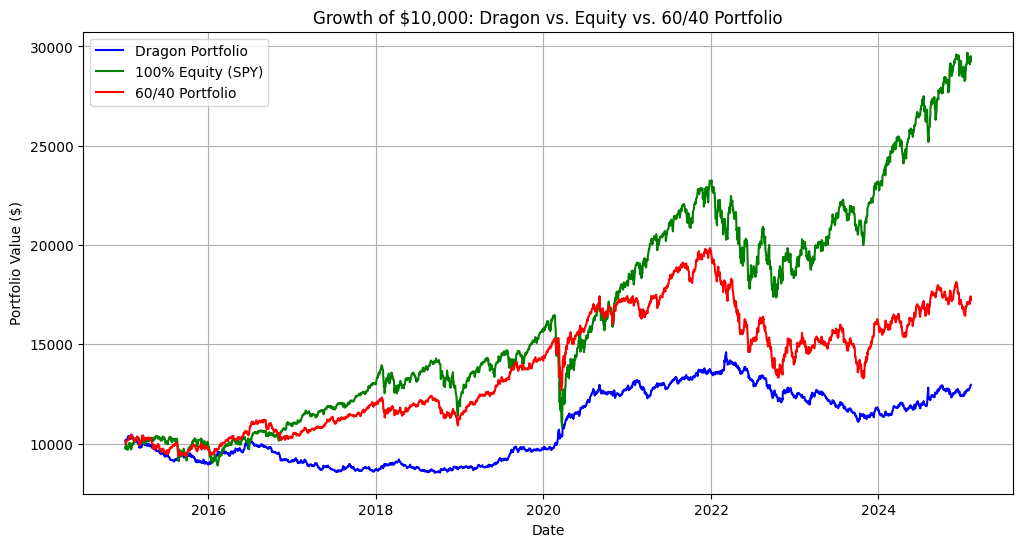

Final Dragon Portfolio Value: $12,957.43
Final 100% Equity Portfolio Value: $29,244.51
Final 60/40 Portfolio Value: $17,250.79


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Dragon Portfolio data
df = dragon_portfolio.copy()
df.set_index("Dates", inplace=True)

# 1️⃣ Compute **Daily Returns**
returns = df.pct_change()

# 2️⃣ Define Portfolio Weights
dragon_weights = np.array([0.18, 0.21, 0.24, 0.18, 0.19])  # DJP, VIXM, SPY, ZROZ, XAU
equity_weights = np.array([0, 0, 1, 0, 0])  # 100% in SPY
sixty_forty_weights = np.array([0, 0, 0.6, 0.4, 0])  # 60% SPY, 40% ZROZ

# 3️⃣ Compute Portfolio Returns
df["Dragon_Portfolio_Return"] = returns.dot(dragon_weights)
df["Equity_Only_Return"] = returns["Equities - SPY US Equity"]  # Only SPY
df["SixtyForty_Return"] = returns.dot(sixty_forty_weights)

# 4️⃣ Compute **Cumulative Return** for each portfolio
df["Dragon_Cumulative"] = (1 + df["Dragon_Portfolio_Return"]).cumprod()
df["Equity_Cumulative"] = (1 + df["Equity_Only_Return"]).cumprod()
df["SixtyForty_Cumulative"] = (1 + df["SixtyForty_Return"]).cumprod()

# 5️⃣ Convert to Portfolio Value (Initial Investment $10,000)
initial_investment = 10_000
df["Dragon_Value"] = initial_investment * df["Dragon_Cumulative"]
df["Equity_Value"] = initial_investment * df["Equity_Cumulative"]
df["SixtyForty_Value"] = initial_investment * df["SixtyForty_Cumulative"]

# 6️⃣ Plot Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Dragon_Value"], label="Dragon Portfolio", color="blue")
plt.plot(df.index, df["Equity_Value"], label="100% Equity (SPY)", color="green")
plt.plot(df.index, df["SixtyForty_Value"], label="60/40 Portfolio", color="red")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Growth of $10,000: Dragon vs. Equity vs. 60/40 Portfolio")
plt.legend()
plt.grid()
plt.show()

# 7️⃣ Print Final Portfolio Values
final_dragon = df["Dragon_Value"].iloc[-1]
final_equity = df["Equity_Value"].iloc[-1]
final_sixty_forty = df["SixtyForty_Value"].iloc[-1]

print(f"Final Dragon Portfolio Value: ${final_dragon:,.2f}")
print(f"Final 100% Equity Portfolio Value: ${final_equity:,.2f}")
print(f"Final 60/40 Portfolio Value: ${final_sixty_forty:,.2f}")
